# Run Immediately

## Libraries

In [65]:
#!%pip install keras tensorflow tensorrt rdkit pydot pydot_ng fsspec s3fs minio

In [66]:
#!sudo apt-get update -y | sudo apt-get install graphviz -y

In [67]:
# Normal Lib
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random

# keras
from keras import Model
import keras
from keras.layers import Conv3D, Input, MaxPooling3D, BatchNormalization, Dense, Dropout, Flatten, AveragePooling3D, Concatenate,Activation, GlobalAveragePooling3D

from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import L2

# Metrics
from scipy.stats import pearsonr, spearmanr # Pearson R best
from keras.metrics import AUC, MeanAbsoluteError, Precision, Recall, Accuracy
from sklearn.metrics import matthews_corrcoef, mean_squared_error, r2_score
from keras.activations import linear
# from sklearn.metrics import mean_squared_error,

# rms = mean_squared_error(y_actual, y_predicted, squared=False)
# Import File
from zipfile import ZipFile
import csv

from rdkit import Chem

# Import File

In [68]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [69]:
import fsspec
import minio
from minio.error import S3Error
from io import BytesIO

In [70]:
# Define your MinIO server credentials
s3_endpoint = 'api.minio.captechvn.com'
s3_access_key = 'NNFVsFeRWZs0dqheqeBp'
s3_secret_key = 'RlKT5ZO6Va5ZI3VH27JzfhSEufD96YXn85ZAgzpA'
bucket = 'ligand-protein-hfmd'

# client = fsspec.filesystem('s3', anon=False, key=access_key, secret=secret_key, client_kwargs={'endpoint_url': f'https://{s3_endpoint}'})
# client.ls(bucket)

In [71]:
minio_client = minio.Minio(
    s3_endpoint,
    access_key=s3_access_key,
    secret_key=s3_secret_key,
    secure=False  # Set to True if using HTTPS
)

In [72]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

/home/jovyan/work/ligand-protein-tay-chan-mieng/Code


Define functions to list and open file from s3 server

In [110]:
def list_dir(folder_name):
    file_list = []
    objects = minio_client.list_objects(bucket, prefix=f'{folder_name}', recursive=True)
    for obj in objects:
        file = os.path.basename(obj.object_name)
        file_list.append(file)
    return file_list
    
def open_file(file_name):
    data = minio_client.get_object(bucket, file_name)
    # Convert to text and readlines
    data = data.read().decode('utf-8').splitlines()
    return data

def read_csv_from_minio(file_path) -> pd.DataFrame:
    data = minio_client.get_object(bucket, file_path)
    df = pd.read_csv(data)
    return df

In [74]:
list_dir("protein/")

['3qzq.pdb',
 '3qzr.pdb',
 '3sjk.pdb',
 '3sjo.pdb',
 '5c1u.pdb',
 '5gso.pdb',
 '5gsw.pdb',
 '7dnc.pdb']

In [75]:
open_file("protein/3qzq.pdb")

['ATOM      1  N   ASP A   5      64.337   7.941  13.977  1.00 43.46      A    N',
 'ATOM      2  CA  ASP A   5      65.286   8.176  12.865  1.00 46.66      A    C',
 'ATOM      3  C   ASP A   5      64.662   8.430  11.517  1.00 40.27      A    C',
 'ATOM      4  O   ASP A   5      64.542   9.595  11.160  1.00 38.54      A    O',
 'ATOM      5  CB  ASP A   5      66.378   7.095  12.831  1.00 46.54      A    C',
 'ATOM      6  CG  ASP A   5      67.330   7.237  14.028  1.00 51.09      A    C',
 'ATOM      7  OD1 ASP A   5      66.806   7.874  14.979  1.00 53.12      A    O',
 'ATOM      8  OD2 ASP A   5      68.549   7.258  13.730  1.00 52.23      A    O',
 'ATOM      9  HA  ASP A   5      65.816   9.083  13.098  1.00 55.99      A    H',
 'ATOM     10  HB2 ASP A   5      65.922   6.098  12.839  1.00 55.85      A    H',
 'ATOM     11  HB3 ASP A   5      66.938   7.204  11.903  1.00 55.85      A    H',
 'ATOM     12  H1  ASP A   5      63.686   8.702  14.058  1.00  0.00      A    H',
 'AT

In [76]:
def get_compound_from_minio(object_name, sanitize=True, removeHs=True, flavor=0):
    try:
        # Download the PDB file from MinIO into memory
        response = minio_client.get_object(bucket, object_name)
        pdb_data = response.read()
        print(f"Downloaded {object_name} from bucket {bucket}.")
    except S3Error as exc:
        print(f"Error occurred: {exc}")
        return None

    if pdb_data:
        # Use BytesIO to create a file-like object from the downloaded data
        pdb_file = BytesIO(pdb_data)

        # RDKit requires a filename, so we'll use a workaround with Chem.MolFromPDBBlock
        pdb_block = pdb_file.getvalue().decode('utf-8')
        compound = Chem.MolFromPDBBlock(pdb_block, sanitize, removeHs, flavor)

        return compound

In [77]:

batch_size = 32
epochs = 200
optimizer=Adam(learning_rate=1e-4)
loss=['mean_squared_error', "binary_crossentropy"]

hypers = [batch_size, epochs, optimizer, loss]
# model.compile(optimizer= optimizer, loss= loss)

# batch_size, epochs, optimizer, loss = hyper_choices
model_type1 = "SFCNN"
# save_path1 = './Save'
# best_path1 = './Best'
sfcnn_save_path = './SFCNN/Save'
sfcnn_best_path = './SFCNN/Best'

model_type2 = "3DCNN"
_3dcnn_save_path = './3DCNN/Save'
_3dcnn_best_path = './3DCNN/Best'

# model_type2 = "3DCNN"
test_save_path = './test/Save'
test_best_path = './test/Best'


## Define global variables

In [78]:
p_folder = f'protein'
p_list = list_dir(p_folder)

l_folder = f'ligand'
l_list = list_dir(l_folder)

la_folder = f'label'
la_list = list_dir(la_folder)

protein_test_path = f'protein/3qzq.pdb'

totalSize = len(l_list)
print(f'Total size: {totalSize}')

permu = np.random.RandomState(seed=69).permutation(totalSize)

train_num, validate_num, test_num = 0,0,0
iDataset_num = totalSize
ratio = (60,20,20)

train_num = int(iDataset_num * (ratio[0]/ (ratio[0]+ratio[1]+ratio[2])))
val_num = int(iDataset_num * (ratio[1]/ (ratio[0]+ratio[1]+ratio[2])))
test_num = int(iDataset_num * (ratio[2]/ (ratio[0]+ratio[1]+ratio[2])))

val_num = 100
test_num = 500
last_num = 2000

train_list_IDs = permu[:train_num]
val_list_IDs = permu[train_num:(train_num+val_num)]
test_list_IDs = permu[(train_num+val_num):(train_num+val_num+test_num)]
last_list_IDs = permu[(train_num+val_num+test_num):(train_num+val_num+test_num+last_num)]


Total size: 16786


In [79]:
permu

array([ 1592, 14669,  5474, ..., 14740,  9818,  4041])

In [80]:
train_list_IDs

array([ 1592, 14669,  5474, ...,  3035,  6871,  6499])

In [81]:
csv_path1_100 = './SFCNN/Report/resultSFCNN100.csv'
csv_path1_500 = './SFCNN/Report/resultSFCNN500.csv'
csv_path1_2000 = './SFCNN/Report/resultSFCNN2000.csv'

csv_path2_100 = './3DCNN/Report/result3DCNN100.csv'
csv_path2_500 = './3DCNN/Report/result3DCNN500.csv'
csv_path2_2000 = './3DCNN/Report/result3DCNN2000.csv'

In [82]:
csv_path3_100 = './test/Report/result3DCNN100.csv'
csv_path3_500 = './test/Report/result3DCNN500.csv'
csv_path3_2000 = './test/Report/result3DCNN2000.csv'

## Classes

In [83]:
#Converts the protein-ligand complexes into 4D tensor.
class Feature_extractor():
    def __init__(self):
        self.atom_codes = {}
        #'others' includs metal atoms and B atom. There are no B atoms on training and test sets.

        others = ([3,4,5,11,12,13]+list(range(19,32))+list(range(37,51))+list(range(55,84)))

        # C and N atoms can be hybridized in three ways and S atom can be hybridized in two ways here.
        # Hydrogen atom is also considered for feature extraction.

        atom_types = [1,(6,1),(6,2),(6,3),(7,1),(7,2),(7,3),8,15,(16,2),(16,3),34,[9,17,35,53],others]

        for i, j in enumerate(atom_types):
            if type(j) is list:
                for k in j:
                    self.atom_codes[k] = i

            else:
                self.atom_codes[j] = i
        self.sum_atom_types = len(atom_types)

    #Onehot encoding of each atom. The atoms in protein or ligand are treated separately.
    def encode(self, atomic_num, molprotein):
        encoding = np.zeros(self.sum_atom_types*2)
        if molprotein == 1:
            encoding[self.atom_codes[atomic_num]] = 1.0
        else:
            encoding[self.sum_atom_types+self.atom_codes[atomic_num]] = 1.0

        return encoding

    #Get atom coords and atom features from the complexes.
    def get_features(self, molecule, molprotein):
        coords = []
        features = []

        # molecule = Chem.MolFromPDBFile(protein_test_path, False, False, 1)
        molecule_conf = molecule.GetConformer()
        molecule_positions = molecule_conf.GetPositions()

        possible_hybridization_list = [
        Chem.rdchem.HybridizationType.UNSPECIFIED,
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
        ]
        for idx, pos in enumerate(molecule_positions):
          coords.append(pos)
          atom = molecule.GetAtomWithIdx(int(idx))
          # print("A")
          # print(atom.GetHybridization())
          if atom.GetAtomicNum() in [6,7,16]:

            hyb = possible_hybridization_list.index(atom.GetHybridization())
            if hyb < 1:
              hyb = 2
            atomicnum = (atom.GetAtomicNum(), hyb)
            features.append(self.encode(atomicnum,molprotein))
          else:
            features.append(self.encode(atom.GetAtomicNum(),molprotein))

        coords = np.array(coords, dtype=np.float32)
        features = np.array(features, dtype=np.float32)

        return coords, features

    #Define the rotation matrixs of 3D stuctures.
    def rotation_matrix(self, t, roller):
        if roller==0:
            return np.array([[1,0,0],[0,np.cos(t),np.sin(t)],[0,-np.sin(t),np.cos(t)]])
        elif roller==1:
            return np.array([[np.cos(t),0,-np.sin(t)],[0,1,0],[np.sin(t),0,np.cos(t)]])
        elif roller==2:
            return np.array([[np.cos(t),np.sin(t),0],[-np.sin(t),np.cos(t),0],[0,0,1]])

    #Generate 3d grid or 4d tensor. Each grid represents a voxel. Each voxel represents the atom in it by onehot encoding of atomic type.
    #Each complex in train set is rotated 9 times for data amplification.
    #The complexes in core set are not rotated.
    #The default resolution is 20*20*20.
    def grid(self,coords, features, resolution=1.0, max_dist=10.0, rotations=9):
        assert coords.shape[1] == 3
        assert coords.shape[0] == features.shape[0]


        grid=np.zeros((rotations+1,20,20,20,features.shape[1]),dtype=np.float32)
        x=y=z=np.array(range(-10,10),dtype=np.float32)+0.5
        for i in range(len(coords)):
            coord=coords[i]
            tmpx=abs(coord[0]-x)
            tmpy=abs(coord[1]-y)
            tmpz=abs(coord[2]-z)
            if np.max(tmpx)<=19.5 and np.max(tmpy)<=19.5 and np.max(tmpz) <=19.5:
                grid[0,np.argmin(tmpx),np.argmin(tmpy),np.argmin(tmpz)] += features[i]

        for j in range(rotations):
            theta = random.uniform(np.pi/18,np.pi/2)
            roller = random.randrange(3)
            coords = np.dot(coords, self.rotation_matrix(theta,roller))
            for i in range(len(coords)):
                coord=coords[i]
                tmpx=abs(coord[0]-x)
                tmpy=abs(coord[1]-y)
                tmpz=abs(coord[2]-z)
                if np.max(tmpx)<=19.5 and np.max(tmpy)<=19.5 and np.max(tmpz) <=19.5:
                    grid[j+1,np.argmin(tmpx),np.argmin(tmpy),np.argmin(tmpz)] += features[i]

        return grid

    def update_grid(self, grid, x, coords, features, resolution=1.0, max_dist=10.0, rotations=9):
        assert coords.shape[1] == 3
        assert coords.shape[0] == features.shape[0]
        y=z=x
        for i in range(len(coords)):
            coord=coords[i]
            tmpx=abs(coord[0]-x)
            tmpy=abs(coord[1]-y)
            tmpz=abs(coord[2]-z)
            if np.max(tmpx)<=19.5 and np.max(tmpy)<=19.5 and np.max(tmpz) <=19.5:
                grid[0,np.argmin(tmpx),np.argmin(tmpy),np.argmin(tmpz)] += features[i]

        for j in range(rotations):
            theta = random.uniform(np.pi/18,np.pi/2)
            roller = random.randrange(3)
            coords = np.dot(coords, self.rotation_matrix(theta,roller))
            for i in range(len(coords)):
                coord=coords[i]
                tmpx=abs(coord[0]-x)
                tmpy=abs(coord[1]-y)
                tmpz=abs(coord[2]-z)
                if np.max(tmpx)<=19.5 and np.max(tmpy)<=19.5 and np.max(tmpz) <=19.5:
                    grid[j+1,np.argmin(tmpx),np.argmin(tmpy),np.argmin(tmpz)] += features[i]

        return grid



In [84]:
def get_atom_features(atom, amino_acid, isprotein):
    ATOM_CODES = {}
    metals = ([3, 4, 11, 12, 13] + list(range(19, 32))
              + list(range(37, 51)) + list(range(55, 84))
              + list(range(87, 104)))
    atom_classes = [(5, 'B'), (6, 'C'), (7, 'N'), (8, 'O'), (15, 'P'), (16, 'S'), (34, 'Se'),
                    ([9, 17, 35, 53], 'halogen'), (metals, 'metal')]
    for code, (atomidx, name) in enumerate(atom_classes):
        if type(atomidx) is list:
            for a in atomidx:
                ATOM_CODES[a] = code
        else:
            ATOM_CODES[atomidx] = code
    try:
        classes = ATOM_CODES[atom.GetAtomicNum()]
    except:
        classes = 9

    possible_chirality_list = [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ]
    chirality = possible_chirality_list.index(atom.GetChiralTag())

    possible_formal_charge_list = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    try:
        charge = possible_formal_charge_list.index(atom.GetFormalCharge())
    except:
        charge = 11

    possible_hybridization_list = [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2,
        Chem.rdchem.HybridizationType.UNSPECIFIED
    ]
    try:
        hyb = possible_hybridization_list.index(atom.GetHybridization())
    except:
        hyb = 6

    possible_numH_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    try:
        numH = possible_numH_list.index(atom.GetTotalNumHs())
    except:
        numH = 9

    possible_implicit_valence_list = [0, 1, 2, 3, 4, 5, 6, 7]
    try:
        valence = possible_implicit_valence_list.index(atom.GetTotalValence())
    except:
        valence = 8

    possible_degree_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    try:
        degree = possible_degree_list.index(atom.GetTotalDegree())
    except:
        degree = 11

    is_aromatic = [False, True]
    aromatic = is_aromatic.index(atom.GetIsAromatic())

    mass = atom.GetMass() / 100

    amino_acids = [
        'ALA', 'ARG', 'ASN', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'
    ]
    if amino_acid in amino_acids:
      amino_acid = amino_acids.index(amino_acid)
    else:
      amino_acid = int(len(amino_acids) + 1)

    return [classes, chirality, charge, hyb, numH, valence, degree, aromatic, mass, amino_acid, isprotein]
    # return [classes, chirality, charge, hyb, numH, valence, degree, aromatic, amino_acid, isprotein]

def get_min_max(compound_positions):
    minx,miny,minz = 999,999,999
    maxx,maxy,maxz = -999,-999,-999
    for pos in compound_positions:
        x, y, z = pos
        if x < minx:
            minx = x

        if y < miny:
            miny = y

        if z < minz:
            minz = z

        if x > maxx:
            maxx = x

        if y > maxy:
            maxy = y

        if z > maxz:
            maxz = z

    return (minx,miny,minz, maxx,maxy,maxz)

def addNotUnique(nuC, uCL):
  x,y,z = nuC

  tmp1 = (x+1, y, z)
  if tmp1 not in uCL:
    uCL.append(tmp1)
    return tmp1

  tmp2 = (x, y+1, z)
  if tmp2 not in uCL:
    uCL.append(tmp2)
    return tmp2

  tmp3 = (x, y, z+1)
  if tmp3 not in uCL:
    uCL.append(tmp3)
    return tmp3

  tmp4 = (x+1, y+1, z)
  if tmp4 not in uCL:
    uCL.append(tmp4)
    return tmp4

  tmp5 = (x+1, y, z+1)
  if tmp5 not in uCL:
    uCL.append(tmp5)
    return tmp5

  tmp6 = (x, y+1, z+1)
  if tmp6 not in uCL:
    uCL.append(tmp6)
    return tmp6

  tmp7 = (x+1, y+1, z+1)
  if tmp7 not in uCL:
    uCL.append(tmp7)
    return tmp7

  tmp8 = (x-1, y, z)
  if tmp8 not in uCL:
    uCL.append(tmp8)
    return tmp8

  tmp9 = (x, y-1, z)
  if tmp9 not in uCL:
    uCL.append(tmp9)
    return tmp9

  tmp10 = (x, y, z-1)
  if tmp10 not in uCL:
    uCL.append(tmp10)
    return tmp10

  tmp11 = (x-1, y-1, z)
  if tmp11 not in uCL:
    uCL.append(tmp11)
    return tmp11

  tmp12 = (x-1, y, z-1)
  if tmp12 not in uCL:
    uCL.append(tmp12)
    return tmp12

  tmp13 = (x, y-1, z-1)
  if tmp13 not in uCL:
    uCL.append(tmp13)
    return tmp13

  tmp14 = (x-1, y-1, z-1)
  if tmp14 not in uCL:
    uCL.append(tmp14)
    return tmp14

def setup_grid(protein_path, ligand_path, isprotein=1):
    compound = get_compound_from_minio(protein_path, False, False, 1)
    compound_conf = compound.GetConformer()
    compound_positions = compound_conf.GetPositions()

    result = get_min_max(compound_positions)

    atoms_aa = []
    readlines = open_file(protein_path)
    for idx, lines in enumerate(readlines):
        if 'HETATM' in lines or 'ATOM' in lines:
            atoms_aa.append(lines[17:20])

    readlines = open_file(ligand_path)
    
    for idx, lines in enumerate(readlines):
        if 'HETATM' in lines or 'ATOM' in lines:
            atoms_aa.append(lines[17:20])
    # print(result)
    # centerx = result[3] - result[0]
    # centery = result[4] - result[1]
    # centerz = result[5] - result[2]
    # print((centerx,centery,centerz))

    uniqueCoord = []
    # repeatedCoord = []

    atom_e = compound.GetAtomWithIdx(int(1))
    features_e = get_atom_features(atom_e, '', 1)
    grid=np.zeros((52,52,52,len(features_e)+3))
    # print(np.shape(grid))

    for idx, coords in enumerate(compound_positions):
      amino_acid = atoms_aa[idx]
      atom = compound.GetAtomWithIdx(int(idx))
      features = get_atom_features(atom, amino_acid, 1)
      # features.append(coords[0])
      # features.append(coords[1])
      # features.append(coords[2])
      features.extend([coords[0],coords[1],coords[2]])
      # print(idx)
      # print(coords)
      # print("-----------")
      x= coords[0] - (result[0] - 1)
      y= coords[1] - (result[1] - 1)
      z= coords[2] - (result[2] - 1)
      roundx = round(x)
      roundy = round(y)
      roundz = round(z)
      checkCoords = (roundx, roundy, roundz)
      # checkCoords2 = (x,y,z)
      if checkCoords not in uniqueCoord:
        uniqueCoord.append(checkCoords)
        grid[roundx, roundy, roundz] = features
      else:
        # repeatedCoord.append(checkCoords2)
        tmpCoord = addNotUnique(checkCoords, uniqueCoord)
        grid[tmpCoord[0], tmpCoord[1], tmpCoord[2]] = features

    con_com = len(compound_positions)
    compound = get_compound_from_minio(ligand_path, False, False, 1)
    compound_conf = compound.GetConformer()
    compound_positions = compound_conf.GetPositions()

    for idx, coords in enumerate(compound_positions):
      amino_acid = atoms_aa[idx+con_com]
      atom = compound.GetAtomWithIdx(int(idx))
      features = get_atom_features(atom, amino_acid, 0)
      features.extend([coords[0],coords[1],coords[2]])

      x= coords[0] - (result[0])
      y= coords[1] - (result[1])
      z= coords[2] - (result[2])
      roundx = round(x)
      roundy = round(y)
      roundz = round(z)
      checkCoords = (roundx, roundy, roundz)
      # checkCoords2 = (x,y,z)
      if checkCoords not in uniqueCoord:
        uniqueCoord.append(checkCoords)
        grid[roundx, roundy, roundz] = features
      else:
        # repeatedCoord.append(checkCoords2)
        tmpCoord = addNotUnique(checkCoords, uniqueCoord)
        grid[tmpCoord[0], tmpCoord[1], tmpCoord[2]] = features


    return grid



## Get data batch

In [109]:
def get_data_batch(dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, index, type_model):
  '''
  
  '''
  core_grids=None
  core_ba= []
  core_stat= []
  # List all files and directories in the dataset folder
  ligand_list = list_dir(ligand_folder)
  protein_list = list_dir(protein_folder)
  label_list = list_dir(label_folder)

  # Get the batch list by index
  batch_list = [value for idx, value in enumerate(dataset_idx) if idx >= index * batch_size and idx < (index+1)*batch_size ]
  if type_model == '3DCNN':
    for i in batch_list:
      # Read all the files in ligand_folder as a list
      # Feature = gridFromCenter()
      complexFile = ligand_list[i]

      # Get Data and Labels
      ## Get the protein name from the complex file, ex: 3qzq-8v_model1.pdb -> 3qzq
      from_protein = complexFile.split('-')[0]
      # Get the complex name from the complex file, ex: 3qzq-8v_model1.pdb -> 3qzq-8v_model1
      complex_name = complexFile.split('.')[0]
      # Get the path to all .pdb files in protein folder
      protein_path = os.path.join(protein_folder, from_protein+'.pdb')
      complexFile_path = os.path.join(ligand_folder, complexFile)

      # grid, minx, miny, minz = set_grid(protein_path)
      # grid = add_ligand(complexFile_path, grid, minx, miny, minz)
      grid = setup_grid(protein_path, complexFile_path)
      if core_grids is None:
          core_grids = []
      core_grids.append(grid)
      grid = []

      protein = [value for value in label_list if from_protein in value][0]
      label_file_path = os.path.join(label_folder, protein)

      df = read_csv_from_minio(label_file_path)
      listidx = df.index[df['file.pdb'] == complex_name].tolist()[0]
      ba = df['BA'][listidx]
      stat = df['Hit/No_hit'][listidx]
      if stat == 'hit':
        stat = 1
      else:
        stat = 0
      core_ba.append(ba)
      core_stat.append(stat)

    core_grids = np.array(core_grids)
    core_ba = np.array(core_ba)
    core_stat = np.array(core_stat)

    return core_grids, core_ba, core_stat


  if type_model == 'SFCNN':
    Feature = Feature_extractor()
    for id in batch_list:
      # if cur_batch*batch_size >=
      ligand_name = ligand_list[id]
      ligand_train_path = os.path.join(ligand_folder, ligand_name)
      # print(ligand_name)
      protein_name1 = ligand_name.split('-')[0]
      protein_name2 = protein_name1
      complex_name = ligand_name.split('.')[0]
      for name in protein_list:
        if protein_name1 in name:
          protein_name1 = name
          continue
      # print(protein_folder)
      protein_train_path = os.path.join(protein_folder, protein_name1)
      protein = get_compound_from_minio(protein_train_path, False, False, 0)
      ligand = get_compound_from_minio(ligand_train_path, False, False, 0)
      # train_complexes.append((protein, ligand))
      coords1, features1 = Feature.get_features(protein,1)
      coords2, features2 = Feature.get_features(ligand,0)
      protein = None
      ligand = None
      center=(np.max(coords2,axis=0)+np.min(coords2,axis=0))/2
      coords=np.concatenate([coords1,coords2],axis = 0)
      features=np.concatenate([features1,features2],axis = 0)
      assert len(coords) == len(features)
      coords = coords-center
      grid=Feature.grid(coords,features, rotations=0)
      if core_grids is None:
          core_grids = grid
      else:
          core_grids = np.concatenate([core_grids,grid],axis = 0)
      grid = []

      label_list = list_dir(label_folder)
      for name in label_list:
        if protein_name2 in name:
          protein_name2 = name
          continue
      label_train_path = os.path.join(label_folder, protein_name2)
      df = read_csv_from_minio(label_train_path)
      listidx = df.index[df['file.pdb'] == complex_name].tolist()[0]
      ba = df['BA'][listidx]
      stat = df['Hit/No_hit'][listidx]
      if stat == 'hit':
        stat = 1
      else:
        stat = 0

      core_ba.append(ba)
      core_stat.append(stat)

    core_ba = np.array(core_ba)
    core_stat = np.array(core_stat)
    return core_grids, core_ba, core_stat



## Other functions

In [86]:
def model_train(model, train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model):
  dataset_len = len(train_dataset_idx)
  runs = dataset_len // batch_size
  cur = 1
  log_txt = "log.txt"
  log_path = os.path.join(save_path, log_txt)
  readline = ''
  if os.path.exists(log_path):
    log_file = open(log_path,"r+")
    readline = log_file.readline()
    log_file.close()
  else:
    with open(log_path, 'w+') as f:
      f.write('0/'+str(runs))
      f.close()

  # If the log file is empty or the number of runs is greater than the dataset length, start from the beginning
  if readline == '' or int(readline.split('/')[0]) > runs or int(readline.split('/')[0]) == 0:
    cur = 1
    model.save(save_path + '.keras')
  else:
    cur = int(readline.split('/')[0])
  check = 0

  print("----------------------- Start TrainDataset ------------------------")
  for i in range(int(cur-1),int(runs)):
    print("=======================Batch "+ str(i+1)+"==============================")
    model = keras.models.load_model(save_path + '.keras')
    print("Get dataset")
    gridList, baList, statList = get_data_batch(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, i, type_model)
    print("----------------------- Train TrainDataset ------------------------")
    model.fit(gridList, [baList, statList], epochs= epochs,verbose=0)
    gridList, baList, statList = [], [], []
    # PearsonR, MSE, RMSE, precision, recall, auc, f1_score, MCC = model_val_dataset(val_dataset_idx, protein_folder, label_folder, label_list, batch_size, epochs, save_path, best_path)
    print("Save")
    model.save(save_path + '.keras')
    log_file = open(log_path,"r+")
    readline = log_file.write(str(i)+'/'+str(runs))
    log_file.close()
    # if PearsonR > checkPearsonR and MCC > checkMCC and RMSE < checkRMSE:
    #   model.save(best_path)
    #   checkPearsonR = PearsonR
    #   checkMCC = MCC
    #   checkRMSE = RMSE
    if check == 0 and batch_size*i >= 2000:
      check +=1
      model.save(best_path + '.keras')
    print("======================= End Batch "+ str(i+1)+"==============================")
  return model

In [87]:
def SFCNN_model(input_shape=(20,20,20,28)):
  inp = Input(shape= input_shape, name='Input_Complexes')

  # Classification

  ## Check there are atoms
  x1 = Conv3D(7,kernel_size=(1,1,1),strides=(1,1,1))(inp)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(7,kernel_size=(3,3,3))(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  # x1 = AveragePooling3D(padding='same')(x1)

  x1 = Conv3D(56,kernel_size=(3,3,3),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = MaxPooling3D(pool_size=2)(x1)

  x1 = Conv3D(112,kernel_size=(3,3,3),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = MaxPooling3D(pool_size=2)(x1)

  x1 = Conv3D(224,kernel_size=(3,3,3),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = MaxPooling3D(pool_size=2)(x1)

  # Global Pooling
  x2 = GlobalAveragePooling3D()(x1)

  x2 = Dense(256)(x2)
  x2 = BatchNormalization()(x2)
  x2 = Activation('relu')(x2)
  x2 = Dropout(0.5)(x2)

  # Flattening
  x1 = Flatten()(x1)

  x1 = Dense(256)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = Dropout(0.5)(x1)

  # Regression Output
  d1 = Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01))(x1)
  # Classification Output
  d2 = Dense(1, activation='sigmoid')(x2)

  return Model(inputs=[inp], outputs=[d1,d2], name='Embedding')

In [88]:
def CNN_model(drop_rate, input_shape= (52,52,52,14)):
  inp = Input(shape= input_shape, name='Input_Complexes')

  ## Check there are atoms
  ## Sketch the pattern of the whole biomolecule
  x1 = Conv3D(filters= 32, kernel_size=(1,1,1),strides=(1,1,1) ,padding='same', bias_initializer='zeros', kernel_initializer='glorot_uniform')(inp)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 8, kernel_size=2, padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 8, kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = MaxPooling3D(pool_size=2)(x1)

  ## Find pattern for chunk size

  x1 = Conv3D(filters= 128,kernel_size=(1,1,1),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 64,kernel_size=2,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 64,kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = MaxPooling3D(pool_size=2)(x1)

  ## Find pattern for amino acid size
  x1 = Conv3D(filters= 256,kernel_size=(1,1,1),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 128,kernel_size=2,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 128,kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = MaxPooling3D(pool_size=2)(x1)

  ## Find pattern for atom interaction size
  x1 = Conv3D(filters= 512,kernel_size=(1,1,1),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 256,kernel_size=2,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 256,kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  # x1 = MaxPooling3D(pool_size=2)(x1)

  #   # Global Pooling
  x2 = GlobalAveragePooling3D()(x1)

  x2 = Dense(256)(x2)
  x2 = BatchNormalization()(x2)
  x2 = Activation('relu')(x2)
  x2 = Dropout(0.5)(x2)

  # # Flattening
  x1 = Flatten()(x1)

  x1 = Dense(256)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = Dropout(0.5)(x1)

  # # Regression Output
  d1 = Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01))(x1)
  # Classification Output
  d2 = Dense(1, activation='sigmoid')(x2)

  # return Model(inputs=[inp], outputs=[d1,d2], name='Embedding')
  return Model(inputs=[inp], outputs=[d1, d2], name='Embedding')


In [89]:
def plot_class(x, y):
  #create scatterplot with regression line
  # plt.scatter(x, y)
  # plt.show()
  # # sns.regplot(y_label, y_pred)
  new_y = []
  for value in y:
    if value >= 0.9:
      new_y.append(1)
    else:
      new_y.append(0)
  confusion_matrix = metrics.confusion_matrix(x, new_y)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Hit", "No_Hit"])

  cm_display.plot()
  plt.show()
  return cm_display

In [90]:
def plot_reg(x, y):
  #create scatterplot with regression line
  #use green as color for individual points
  X = np.array(x)
  plt.plot(x, y, 'o', color='green')

  #obtain m (slope) and b(intercept) of linear regression line
  m, b = np.polyfit(x, y, 1)


  #use red as color for regression line
  plt.plot(X, m*X+b, color='red')


In [91]:
import math

In [92]:
def get_metrics(y_label, y_pred, ytype):
  '''
  A function to calculate the metrics of the model

  ## Parameters:
  - y_label: The true labels
  - y_pred: The predicted labels
  - ytype: The type of the labels, 0 for regression and 1 for classification

  ## Returns:
  ### Classification:
    - precision
    - recall
    - specificity
    - NPV
    - MCC
  ### Regression:
    - PearsonR
    - p1
    - MSE
    - rms
    - rho
    - p2
  '''

  if ytype == 0: # Regression
    print("++++++++++++++++++++++++++Regression++++++++++++++++++++++++++")
    PearsonR, p1 = pearsonr(y_label, y_pred)
    print('Pearson Correlation Coefficient: ' + str(PearsonR))
    print('P value: ' + str(p1))
    MSE = MeanAbsoluteError()
    MSE.update_state(y_label, y_pred)
    MSE = MSE.result().numpy()
    print('Mean Absolute Error: ' + str(MSE))

    rms = mean_squared_error(y_label, y_pred, squared=False)
    # rms = math.sqrt(mean_squared_error(y_label, y_pred, squared=False))
    print('Root Mean Error: ' + str(rms))

    r2 =r2_score(y_label, y_pred)
    print('Correlation of Covariance: ' + str(r2))

    rho, p2 = spearmanr(y_label, y_pred)
    print('Spearman Rank Correlation Coefficient: ' + str(rho))
    print('P value: ' + str(p2))

    # plot_reg(y_label, y_pred)

    return PearsonR, p1, MSE, rms, rho, p2

  if ytype == 1: # Classification
    print("+++++++++++++++++++++++Classification+++++++++++++++++++++++")

    tp = keras.metrics.TruePositives(thresholds= 0.9)
    tn = keras.metrics.TrueNegatives(thresholds= 0.9)
    fp = keras.metrics.FalsePositives(thresholds= 0.9)
    fn = keras.metrics.FalseNegatives(thresholds= 0.9)


    tp.update_state(y_label, y_pred)
    tn.update_state(y_label, y_pred)
    fp.update_state(y_label, y_pred)
    fn.update_state(y_label, y_pred)

    tp = tp.result().numpy()
    tn = tn.result().numpy()
    fp = fp.result().numpy()
    fn = fn.result().numpy()

    precision = tp/ (tp+fp) # PPV
    print('Precision: ' + str(precision))

    recall = tp/(tp+fn) # Recall - TPR
    print('Recall: ' + str(recall))

    specificity = tn/(tn+fp)
    print('Specificity: ' + str(specificity))

    NPV = tn/(tn+fn)
    print('NPV: ' + str(NPV))

    MCC = (tp*tn - fp*fn)/ math.sqrt(   (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) # Phi coefficient
    print("Phi coefficient:" + str(MCC))

    return precision, recall, specificity, NPV, MCC

In [93]:
def model_val_dataset(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model):
  '''
  This function is used to validate the model with the validation dataset

  ## Parameters:
  - val_dataset_idx: list of index of the validation dataset
  - protein_folder: path to the protein folder
  - ligand_folder: path to the ligand folder
  - label_folder: path to the label folder
  - batch_size: size of the batch
  - epochs: number of epochs
  - save_path: path to save the model
  - best_path: path to save the best model
  - type_model: type of the model (3DCNN or SFCNN)

  ## Returns:
  - ba_Actual: list of actual binding affinity
  - ba_Pred: list of predicted binding affinity
  - stat_Actual: list of actual status (hit or no hit)
  - stat_Pred: list of predicted status (hit or no hit)
  - reg_res: list of regression metrics
  - class_res: list of classification metrics
  '''
  # dataset_len = len(val_dataset_idx)
  # runs = dataset_len // batch_size
  # model = keras.models.load_model(save_path)
  dataset_len = len(val_dataset_idx)
  runs = dataset_len // batch_size
  last_batch = dataset_len - batch_size*runs
  model = keras.models.load_model(save_path + '.keras')
  # PearsonR_list, MCC_list, RSME_list = 0,0,0
  ba_Actual, stat_Actual, ba_Pred, stat_Pred = [], [], [], []

  print("----------------------- Start ValDataset ------------------------")
  for i in range(int(runs+1)):

    print("Get dataset on batch "+str(i+1))
    if i != runs+1:
      gridList, baList, statList = get_data_batch(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, i, type_model)
    else:
      gridList, baList, statList = get_data_batch(val_dataset_idx, protein_folder, ligand_folder, label_folder, last_batch, i, type_model)

    print("----------------------- Predict ValDataset ------------------------")
    result = model.predict(gridList, verbose=2)
    gridList = []
    pred_reg, pred_class = result

    baList = [value for value in baList.tolist()]
    statList = [value for value in statList.tolist()]

    pred_reg = [value[0] for value in pred_reg.tolist()]
    pred_class = [value[0] for value in pred_class.tolist()]

    if ba_Actual == []:
      ba_Actual = baList
      stat_Actual = statList
      ba_Pred = pred_reg
      stat_Pred = pred_class
    else:
      ba_Actual.extend(baList)
      stat_Actual.extend(statList)
      ba_Pred.extend(pred_reg)
      stat_Pred.extend(pred_class)

    baList, statList = [], []

  reg_res = get_metrics(ba_Actual, ba_Pred, 0)
  print("-------------------------------------------------------------")
  class_res = get_metrics(stat_Actual, stat_Pred, 1)

  return ba_Actual, ba_Pred, stat_Actual, stat_Pred, reg_res, class_res

In [94]:
def exportCSV(ligand_folder, pred_list, result, csv_path):
  '''
  This function is used to export the result to a csv file

  ## Parameters:
  - ligand_folder: path to the ligand folder
  - pred_list: list of index of the prediction
  - result: list of result
  - csv_path: path to save the csv file
  '''
  fields = ['Model', 'BindingAffinity_Label', 'BindingAffinity_Prediction', 'Hit_Label', 'Hit_Prediction']
  # fields = ['Model', 'Hit_Label', 'Hit_Prediction', 'BindingAffinity_Label', 'BindingAffinity_Prediction']
  rows = []
  ligand_list = list_dir(ligand_folder)
  for idx, value in enumerate(pred_list):
    row = []
    row.append(ligand_list[value])
    row.append(result[0][idx])
    row.append(result[1][idx])
    row.append(result[2][idx])
    row.append(result[3][idx])

    rows.append(row)

  with open(csv_path, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(rows)
  csvfile.close()

## Confirmed Scripts

In [95]:
def hyper_train(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model, hyper_choices):
  model = None
  if type_model == 'SFCNN':
    model = SFCNN_model()
  if type_model == '3DCNN':
    model = CNN_model(0.5)


  if model != None:
    batch_size, epochs, optimizer, loss = hyper_choices
    model.compile(optimizer= optimizer,
                  loss= loss)
    model_train(model, train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model)

In [96]:
def exportVal(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model, csv_path):
  result = model_val_dataset(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model)
  exportCSV(ligand_folder,val_dataset_idx,result,csv_path)
  return result

In [97]:
def test_model(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model, hyper_choices):
  model = None
  if type_model == 'SFCNN':
    model = SFCNN_model()
  if type_model == '3DCNN':
    model = CNN_model(0.5)


  if model != None:
    batch_size, epochs, optimizer, loss = hyper_choices
    model.compile(optimizer= optimizer,
                  loss= loss)
    model.summary()
#     model.save('/content/temp')
    for i in range(312):
      print("Batch "+ str(i+1))
#       model = keras.models.load_model('/content/temp')
      gridList, baList, statList = get_data_batch(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, i, type_model)
      model.fit(gridList, [baList, statList], epochs= epochs,verbose=0)
      gridList, baList, statList = [], [], []
#       model.save('/content/temp')
#     # model_train(model, train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model)
  return model

## Setup Hyperparameters

In [98]:
def cus_class_loss(y_label, y_pred):
    tp = keras.metrics.TruePositives(thresholds= 0.9)
    tn = keras.metrics.TrueNegatives(thresholds= 0.9)
    fp = keras.metrics.FalsePositives(thresholds= 0.9)
    fn = keras.metrics.FalseNegatives(thresholds= 0.9)


    tp.update_state(y_label, y_pred)
    tn.update_state(y_label, y_pred)
    fp.update_state(y_label, y_pred)
    fn.update_state(y_label, y_pred)

    tp = tp.result().numpy()
    tn = tn.result().numpy()
    fp = fp.result().numpy()
    fn = fn.result().numpy()
    loss_MCC = (tp*tn - fp*fn)/ math.sqrt(   (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  )
    return loss_MCC

## See Model Summary

In [99]:
from keras.utils import plot_model

In [100]:
test3DCNNModel = keras.models.load_model(test_save_path + '.keras')
# test3DCNNModel.summary()
plot_model(test3DCNNModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [101]:
testSFCNNModel = keras.models.load_model(sfcnn_save_path + '.keras')
# testSFCNNModel.summary()
plot_model(testSFCNNModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Create Comparision Reg Plot

In [102]:
def run_plots(result_model):
  plot_reg(result_model[0], result_model[1])
  plot_class(result_model[2], result_model[3])

## Run training SFCNN

In [111]:
hyper_train(train_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, sfcnn_save_path, sfcnn_best_path, model_type1, hypers)

----------------------- Start TrainDataset ------------------------
=======================Batch 313==============================
Get dataset
Downloaded protein/5c1u.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/5c1u-9_model82.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded protein/5c1u.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/5c1u-AG_model23.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded protein/5gsw.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/5gsw-8w_model88.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded protein/5c1u.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/5c1u-NK19k_model50.

I0000 00:00:1717560074.177035   20460 service.cc:145] XLA service 0x70aa980023d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717560074.177120   20460 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-05 04:01:14.352325: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-05 04:01:14.978445: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1717560076.850415   22139 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2601', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1717560076.852251   22113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1244', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:17

Save
======================= End Batch 313==============================
=======================Batch 314==============================
Get dataset
Downloaded protein/5gsw.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/5gsw-8v_model84.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded protein/3qzr.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/3qzr-SG_model50.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded protein/5gsw.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/5gsw-10b_model36.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded protein/5gsw.pdb from bucket ligand-protein-hfmd.
Successfully loaded the molecule from the PDB data.
Downloaded ligand/5gsw-FIP_mod

In [ ]:
resultSFCNN1 = exportVal(val_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, sfcnn_save_path, sfcnn_best_path, model_type1, csv_path1_100)

----------------------- Start ValDataset ------------------------
Get dataset on batch 1
----------------------- Predict ValDataset ------------------------
1/1 - 1s - 919ms/step
Get dataset on batch 2
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 36ms/step
Get dataset on batch 3
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 38ms/step
Get dataset on batch 4
----------------------- Predict ValDataset ------------------------
1/1 - 1s - 768ms/step
++++++++++++++++++++++++++Regression++++++++++++++++++++++++++
Pearson Correlation Coefficient: 0.14612715012849328
P value: 0.14686364561328558
Mean Absolute Error: 0.5106867
Root Mean Error: 0.6268775206565783
Correlation of Covariance: -0.46810656917731874
Spearman Rank Correlation Coefficient: 0.07206348515439345
P value: 0.47615409259333186
-------------------------------------------------------------
+++++++++++++++++++++++Classification+++++++++++++++++++++++
Precision: 0.

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


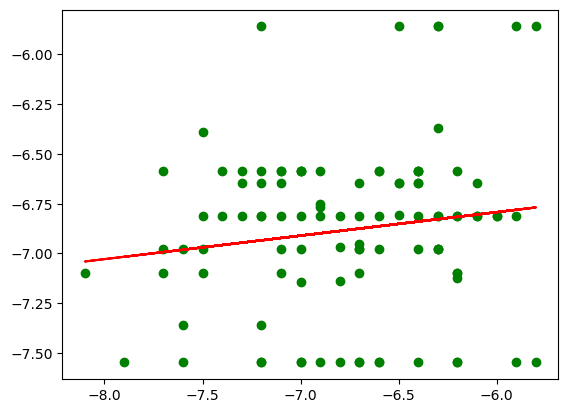

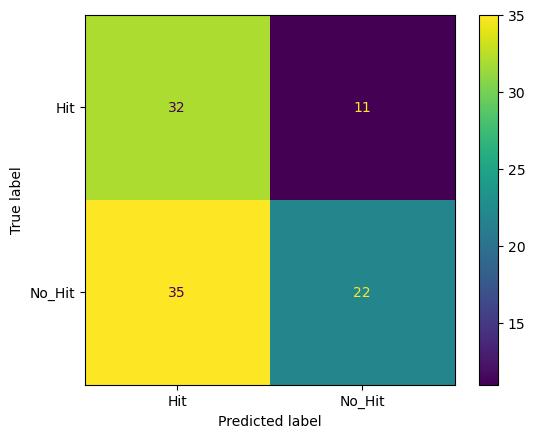

In [ ]:
# plot_reg(resultSFCNN1[0], resultSFCNN1[1])
# plot_class(resultSFCNN1[2], resultSFCNN1[3])
run_plots(resultSFCNN1)

In [ ]:
resultSFCNN2 = exportVal(test_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, sfcnn_save_path, sfcnn_best_path, model_type1, csv_path1_500)

----------------------- Start ValDataset ------------------------
Get dataset on batch 1
----------------------- Predict ValDataset ------------------------
1/1 - 1s - 942ms/step
Get dataset on batch 2
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 39ms/step
Get dataset on batch 3
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 40ms/step
Get dataset on batch 4
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 38ms/step
Get dataset on batch 5
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 38ms/step
Get dataset on batch 6
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 40ms/step
Get dataset on batch 7
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 52ms/step
Get dataset on batch 8
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 39ms/step
Get dataset on batch 9
--------------

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# plot_reg(resultSFCNN2[0], resultSFCNN2[1])
# plot_class(resultSFCNN2[2], resultSFCNN2[3])
run_plots(resultSFCNN2)

In [ ]:
resultSFCNN3 = exportVal(last_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, sfcnn_save_path, sfcnn_best_path, model_type1, csv_path1_2000)

In [ ]:
# plot_reg(resultSFCNN3[0], resultSFCNN3[1])
# plot_class(resultSFCNN3[2], resultSFCNN3[3])
run_plots(resultSFCNN3)

In [ ]:
# model_test = keras.models.load_model(save_path1)
# model_test.summary()

## Run training 3DCNN

In [ ]:
hyper_train(train_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, test_save_path, test_best_path, model_type2, hypers)

In [ ]:
# exportVal(val_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, save_path2, best_path2, model_type2, csv_path3_100)

In [ ]:
result3DCNN4 = exportVal(val_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, test_save_path, test_best_path, model_type2, csv_path3_100)

In [ ]:
run_plots(result3DCNN4)

In [ ]:
result3DCNN5 = exportVal(test_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, test_save_path, test_best_path, model_type2, csv_path3_500)

In [ ]:
run_plots(result3DCNN5)

In [ ]:
result3DCNN6 = exportVal(last_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, test_save_path, test_best_path, model_type2, csv_path3_2000)

In [ ]:
run_plots(result3DCNN6)

In [ ]:
model_test = keras.models.load_model(test_save_path)
model_test.summary()